In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import cost, Minuit
from csaps import csaps
from scipy.signal import butter, freqs

%config InlineBackend.figure_formats = ['svg']

units are always mK, pJ, pW, Ohm, H, muA, V, s, Hz, mm, keV, g, ...

In [2]:
utils_par = {
    # 'bath_temperature': 11,  # mK
    'T_mc': 15,  # mK
    'T_shunt': 11,  # mK
    'Rh': 10,  # Ohm
    'Rs': 0.040,  # Ohm
    'L': 3.5e-7, # H 
    'sample_frequency': 25000,  # Hz
    'record_length': 16384, 
            }
utils_par['t'] = np.arange(0, utils_par['record_length'])/utils_par['sample_frequency']
utils_par['freq'] = np.fft.rfftfreq(utils_par['record_length'], d=1/utils_par['sample_frequency'])

# extract info from pulse shape

In [3]:
path = '../../rltest_data/'

names = ['li1p', 'li1l', 'li2p']

channels = {'li1p': 1, 'li1l': 2, 'li2p': 6,}

sev = {'li1p': np.loadtxt(path + 'Channel_0_SEV_Particle.xy', skiprows=3), 
       'li1l': np.loadtxt(path + 'Channel_1_SEV_Direct.xy', skiprows=3), 
       'li2p': np.loadtxt(path + 'Channel_5_SEV_Particle.xy', skiprows=3)}


## pulse shape fit

In [4]:
def pulse_template(t, t0, An, At, tau_n, tau_in, tau_t):
    n = t.shape[0]
    cond = t > t0
    pulse = np.zeros(n)
    pulse[cond] = (An * (np.exp(-(t[cond] - t0) / tau_n) - np.exp(-(t[cond] - t0) / tau_in)) + \
                   At * (np.exp(-(t[cond] - t0) / tau_t) - np.exp(-(t[cond] - t0) / tau_n)))
    return pulse

In [5]:
def single_pulse(t, t0, A, tau_rise, tau_decay):
    n = t.shape[0]
    cond = t > t0
    pulse = np.zeros(n)
    pulse[cond] = A * (np.exp(-(t[cond] - t0) / tau_decay) - np.exp(-(t[cond] - t0) / tau_rise))
    return pulse

### Particle pulses

In [6]:
pspars = {'li1p': [-2.74038416, 1.18433165, 1.04116448, 72.05835566, 0.38244691, 9.35751479], 
          'li1l': [-1.330066039435939, 1.0952134272841865, 0.6847593878712344, 17.83502246386849, 0.09396510359613783, 3.6836775281151417], 
          'li2p': [-2.06154929, 1.1372723, 0.94300337, 79.26274212, 0.39666609, 12.05657907]}

In [7]:
pspars_fit = {}
pspars_std = {}
minis = {}

for name in names:
    
    c = cost.LeastSquares(x=sev[name][:,0]*1000, y=sev[name][:,1], yerror=1e-3*np.ones(sev[name].shape[0]), model=pulse_template)
    
    minis[name] = Minuit(c, *pspars[name])

    minis[name].migrad()  # run optimiser
    minis[name].hesse()   # run covariance estimator

    pspars_fit[name] = np.array(minis[name].values)
    pspars_std[name] = np.sqrt(np.diag(list(minis[name].covariance)))

In [8]:
# minis['li1p'].hesse()

In [9]:
# minis['li1p'].hesse()

In [10]:
# minis['li1p'].draw_mncontour("An", "At")

In [11]:
pspars_fit

{'li1p': array([-2.74038416,  1.18433165,  1.04116448, 72.05835566,  0.38244691,
         9.35751479]),
 'li1l': array([-1.33006601,  1.05565334,  0.66002543, 17.83502825,  0.09396504,
         3.68367896]),
 'li2p': array([-2.06154929,  1.1372723 ,  0.94300337, 79.26274212,  0.39666609,
        12.05657907])}

In [12]:
pspars_std

{'li1p': array([0.00022561, 0.00022445, 0.00020167, 0.07450532, 0.00037006,
        0.00394843]),
 'li1l': array([9.85020702e-05, 3.47961430e-04, 5.28301457e-04, 2.03654339e-02,
        1.62348056e-04, 6.09889716e-03]),
 'li2p': array([0.00023489, 0.00018862, 0.00018453, 0.06414667, 0.00037269,
        0.00547734])}

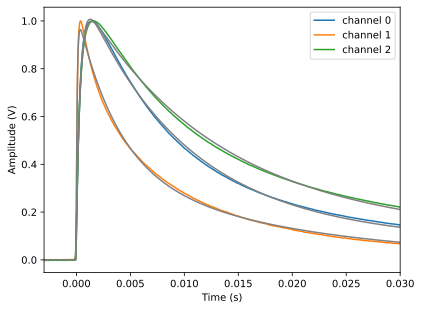

In [13]:
t0 = [-0.0027, -0.0013, -0.002]

for c,name in enumerate(names):
    plt.plot(sev[name][:,0] - t0[c], sev[name][:,1], label=f'channel {c}')
    plt.plot(sev[name][:,0] - t0[c], pulse_template(sev[name][:,0]*1000, *pspars_fit[name]), color='grey')
    
plt.xlim(-0.003,0.03)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

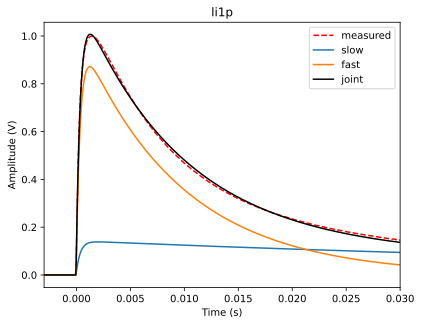

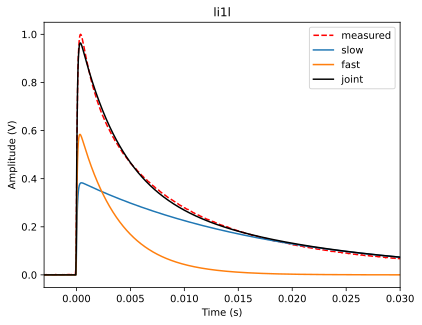

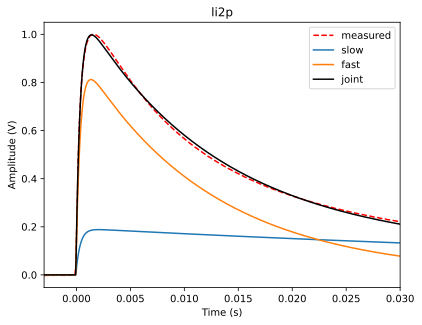

In [14]:
t0 = [-0.0027, -0.0013, -0.002]

for c,name in enumerate(names):
    plt.plot(sev[name][:,0] - t0[c], sev[name][:,1], 
             label='measured', color='red', linestyle='dashed')
    fast_pulse = single_pulse(sev[name][:,0]*1000, 
                          pspars_fit[name][0], 
                          pspars_fit[name][2],
                          pspars_fit[name][4],
                          pspars_fit[name][5])
    slow_pulse = single_pulse(sev[name][:,0]*1000, 
                          pspars_fit[name][0],
                          pspars_fit[name][1] - pspars_fit[name][2],
                          pspars_fit[name][4],
                          pspars_fit[name][3])
    plt.plot(sev[name][:,0] - t0[c], slow_pulse, label='slow')
    plt.plot(sev[name][:,0] - t0[c], fast_pulse, label='fast')
    plt.plot(sev[name][:,0] - t0[c], fast_pulse + slow_pulse, 
             color='black', label='joint')
    
    plt.xlim(-0.003,0.03)
    plt.legend()
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (V)')
    plt.show()

In [15]:
Afast = {}
Aslow = {}
tau_rise = {}
tau_fast = {}
tau_slow = {}

for name in names:
    Afast[name] = pspars_fit[name][2]
    Aslow[name] = pspars_fit[name][1] - pspars_fit[name][2]
    tau_rise[name] = pspars_fit[name][4]*1e-3  # s
    tau_fast[name] = pspars_fit[name][5]*1e-3  # s
    tau_slow[name] = pspars_fit[name][3]*1e-3  # s

In [16]:
Afast

{'li1p': 1.04116448, 'li1l': 0.6600254261826252, 'li2p': 0.94300337}

In [17]:
Aslow

{'li1p': 0.14316717000000012, 'li1l': 0.3956279154612071, 'li2p': 0.19426893}

In [18]:
tau_rise

{'li1p': 0.00038244691, 'li1l': 9.396504105641667e-05, 'li2p': 0.00039666609}

In [19]:
tau_fast

{'li1p': 0.00935751479, 'li1l': 0.003683678964822836, 'li2p': 0.01205657907}

In [20]:
tau_slow

{'li1p': 0.07205835566,
 'li1l': 0.017835028251184513,
 'li2p': 0.07926274212000001}

### Test pulses

In [21]:
sev_tp = {'li1p': np.loadtxt(path + 'Channel_0_SEV_TP.xy', skiprows=3), 
       'li1l': np.loadtxt(path + 'Channel_1_SEV_TP.xy', skiprows=3), 
       'li2p': np.loadtxt(path + 'Channel_5_SEV_TP.xy', skiprows=3)}


In [22]:
pspars_fit_tp = {}
pspars_std_tp = {}
minis_tp = {}

for name in names:
    
    c = cost.LeastSquares(x=sev_tp[name][:,0]*1000, y=sev_tp[name][:,1], yerror=1e-3*np.ones(sev[name].shape[0]), model=pulse_template)
    
    minis_tp[name] = Minuit(c, *pspars[name])

    minis_tp[name].migrad()  # run optimiser
    minis_tp[name].hesse()   # run covariance estimator

    pspars_fit_tp[name] = np.array(minis_tp[name].values)
    pspars_std_tp[name] = np.sqrt(np.diag(list(minis_tp[name].covariance)))

In [23]:
pspars_fit_tp

{'li1p': array([  1.64357738,   2.06154618,   1.91145547, 189.06776743,
          4.86610114,  17.98445302]),
 'li1l': array([ 0.83735524,  2.32336109,  0.23449355,  7.84386577,  2.50458016,
        35.92026572]),
 'li2p': array([  1.77721804,   1.8031504 ,   1.63621984, 200.16861639,
          5.01015545,  22.92536527])}

In [24]:
pspars_std_tp

{'li1p': array([0.00062647, 0.00091797, 0.00085851, 0.11713071, 0.00195123,
        0.00637387]),
 'li1l': array([0.00044357, 0.00307308, 0.00079886, 0.0094693 , 0.00218258,
        0.06931968]),
 'li2p': array([0.0006609 , 0.00057552, 0.00050924, 0.12178979, 0.00179341,
        0.00748518])}

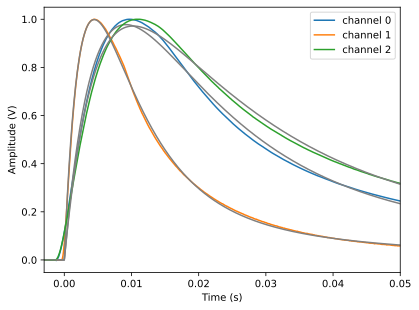

In [25]:
t0 = [0.00164357738, 0.00083735524, 0.00177721804]

for c,name in enumerate(names):
    plt.plot(sev_tp[name][:,0] - t0[c], sev_tp[name][:,1], label=f'channel {c}')
    plt.plot(sev_tp[name][:,0] - t0[c], pulse_template(sev_tp[name][:,0]*1000, *pspars_fit_tp[name]), color='grey')
    
plt.xlim(-0.003,0.05)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

In [26]:
Afast_tp = {}
Aslow_tp = {}
tau_rise_tp = {}
tau_fast_tp = {}
tau_slow_tp = {}

for name in names:
    Afast_tp[name] = pspars_fit_tp[name][2]
    Aslow_tp[name] = pspars_fit_tp[name][1] - pspars_fit_tp[name][2]
    tau_rise_tp[name] = pspars_fit_tp[name][4]*1e-3  # s
    tau_fast_tp[name] = pspars_fit_tp[name][5]*1e-3  # s
    tau_slow_tp[name] = pspars_fit_tp[name][3]*1e-3  # s

In [27]:
tau_rise_tp

{'li1p': 0.004866101142065952,
 'li1l': 0.0025045801580489205,
 'li2p': 0.005010155447536873}

In [28]:
tau_fast_tp

{'li1p': 0.01798445302006269,
 'li1l': 0.03592026571512914,
 'li2p': 0.022925365269366556}

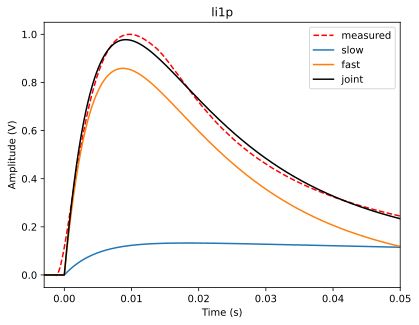

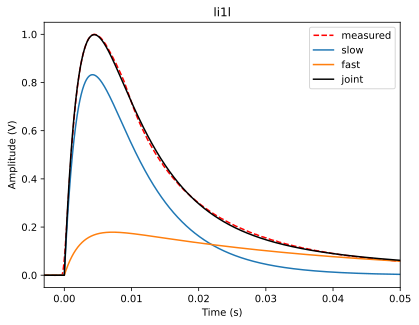

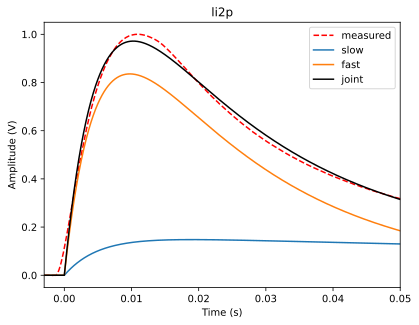

In [29]:
for c,name in enumerate(names):
    plt.plot(sev_tp[name][:,0] - pspars_fit_tp[name][0]/1000, sev_tp[name][:,1], 
             label='measured', color='red', linestyle='dashed')
    fast_pulse = single_pulse(sev_tp[name][:,0]*1000, 
                          0., 
                          Afast_tp[name],
                          tau_rise_tp[name]*1e3,
                          tau_fast_tp[name]*1e3)
    slow_pulse = single_pulse(sev_tp[name][:,0]*1000, 
                          0.,
                          Aslow_tp[name],
                          tau_rise_tp[name]*1e3,
                          tau_slow_tp[name]*1e3)
    plt.plot(sev_tp[name][:,0], slow_pulse, label='slow')
    plt.plot(sev_tp[name][:,0], fast_pulse, label='fast')
    plt.plot(sev_tp[name][:,0], fast_pulse + slow_pulse, 
             color='black', label='joint')
    
    plt.xlim(-0.003,0.05)
    plt.legend()
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (V)')
    plt.show()

## transition curve splines

In [30]:
tes_rt0 = {'li1p': 0.110, 'li1l': 0.115, 'li2p': 0.100, }  # Ohm
bias = {'li1p': 0.28 * 17.86, 'li1l': 0.084 * 17.86, 'li2p': 0.336 * 17.86,}  # muA

In [31]:
# Attention - this curve is actually taken with 1 muA!

transition_curves = np.loadtxt(path + 'rl_tests.xy', skiprows=5)[2600:10000]

transition_curves = {'li1p': transition_curves[:,[0,1]], 
                     'li1l': transition_curves[:,[0,2]], 
                     'li2p': transition_curves[:,[0,3]]}

In [32]:
def temp_trafo(x, limits, stretch):
    return (x - limits[1])*stretch + limits[1]

In [33]:
tes_tc = {'li1p': 31, 'li1l': 22.5, 'li2p': 29, }  # mK
tes_width = {'li1p': 1, 'li1l': 1.7, 'li2p': 1.5, }  # mK

self_heating_widening = {'li1p': 0.2, 'li1l': 0.07, 'li2p': 0.3, }  # mK

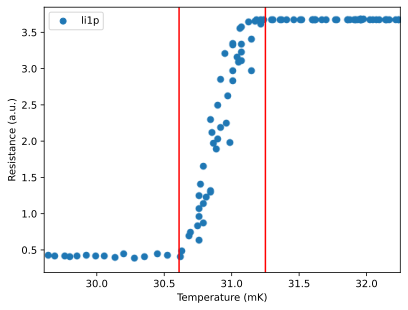

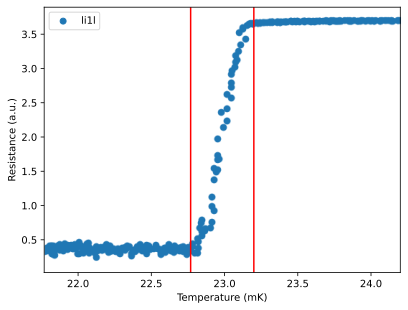

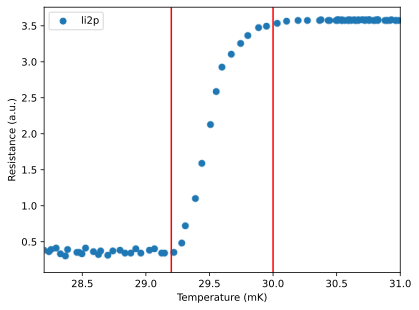

In [34]:
limits = {'li1p': np.array([30.45, 31.25]), 
          'li1l': np.array([22.75, 23.2]), 
          'li2p': np.array([29, 30.]),}
stretch = {}
for name in names:
    stretch[name] = (tes_width[name] - self_heating_widening[name])/tes_width[name]  # (bias[name]) ** (1/2)

for name in names:
    plt.scatter(temp_trafo(transition_curves[name][:,0], limits[name], stretch[name]), 
                transition_curves[name][:,1], label=name, rasterized=True)
    for i in range(2):
        plt.axvline(temp_trafo(limits[name][i], limits[name], stretch[name]), color='red')
    plt.ylabel('Resistance (a.u.)')
    plt.xlabel('Temperature (mK)')
    plt.xlim((temp_trafo(limits[name][0], limits[name], stretch[name]) - 1, temp_trafo(limits[name][1], limits[name], stretch[name]) + 1))
    plt.legend()
    plt.show()

In [35]:
for name in names:
    transition_curves[name][:,0] = temp_trafo(transition_curves[name][:,0], limits[name], stretch[name])
    limits[name] = temp_trafo(limits[name], limits[name], stretch[name])

In [36]:
transition_curves_sorted = {}
transition_curves_cleaned = {}
temp_grids = {'li1p': np.linspace(25,35, 1000),
              'li1l': np.linspace(18,28, 1000),
              'li2p': np.linspace(20,35, 1000),}
transition_curve_splines = {}
transition_curve_derivative_splines = {}
xlims = {}
for name in names:
    xlims[name] = (limits[name][0] - 1, limits[name][1] + 1)

for name in names:
    transition_curves_sorted[name] = np.sort(transition_curves[name], axis=0)

    transition_curves_cleaned[name] = []
    for v in np.unique(transition_curves_sorted[name][:,0]):
        transition_curves_cleaned[name].append(np.mean(
            transition_curves_sorted[name][transition_curves_sorted[name][:,0] == v], axis=0))
    transition_curves_cleaned[name] = np.array(transition_curves_cleaned[name])
    
    transition_curves[name][:,1] = transition_curves[name][:,1]/np.max(transition_curves_cleaned[name][:,1]) * tes_rt0[name]
    transition_curves_cleaned[name][:,1] = transition_curves_cleaned[name][:,1]/np.max(transition_curves_cleaned[name][:,1]) * tes_rt0[name]
    
    transition_curve_splines[name] = csaps(transition_curves_cleaned[name][:,0], 
                                           transition_curves_cleaned[name][:,1], 
                                           temp_grids[name], smooth=0.99999)
    
    transition_curve_derivative_splines[name] = csaps(transition_curves_cleaned[name][:,0], 
                                           np.gradient(transition_curves_cleaned[name][:,1], 
                                                       transition_curves_cleaned[name][:,0]), 
                                           temp_grids[name], smooth=0.9999)

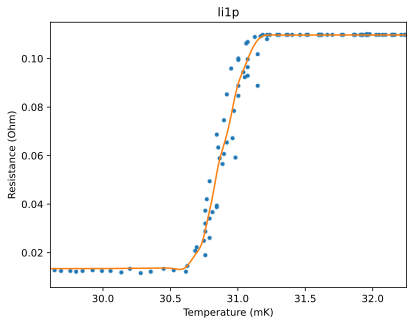

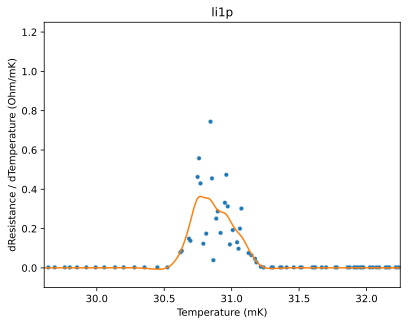

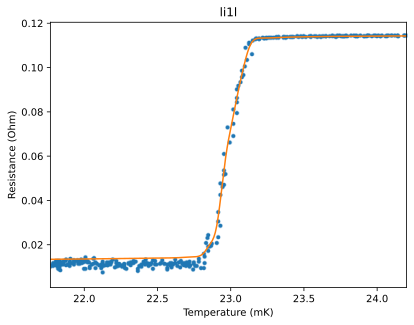

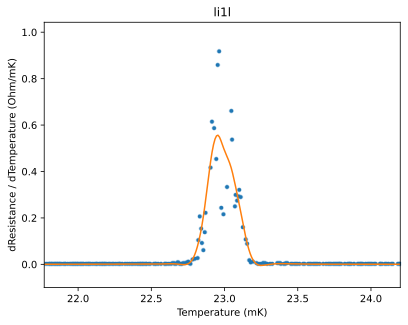

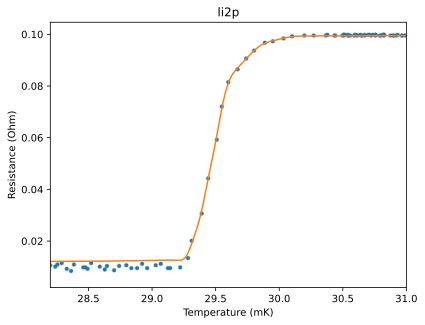

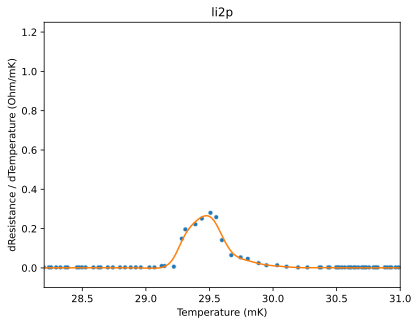

In [37]:
for name in names:
    plt.scatter(transition_curves[name][:,0], transition_curves[name][:,1], s=10, rasterized=True)
    plt.plot(temp_grids[name], transition_curve_splines[name], color='C1')
    plt.xlabel('Temperature (mK)')
    plt.ylabel('Resistance (Ohm)')
    plt.title(name)
    plt.xlim(xlims[name])
    plt.show()
    
    plt.scatter(transition_curves_cleaned[name][:,0], 
                np.gradient(transition_curves_cleaned[name][:,1], transition_curves_cleaned[name][:,0]), s=10, rasterized=True)
    plt.plot(temp_grids[name], transition_curve_derivative_splines[name], color='C1')
    plt.xlabel('Temperature (mK)')
    plt.ylabel('dResistance / dTemperature (Ohm/mK)')
    plt.xlim(xlims[name])
    plt.title(name)
    plt.ylim(-0.1,1/stretch[name])
    plt.show()

## pulse heights in temperature

SQUID sensitivity * 100

U / phi0 8.65

I / phi0 0.15

In [38]:
# for this we need the transition curve and the OP at the point where A_fast was measured
# scale the transition curve to the bias current and get derivative at DAC
# get V/phi_0 from Heater bias client: Phi-0 [Volt / Phi-0]: 8.65
# the input coil sensitivity is then 0.15 muA/phi_0
# therefore 8.65 V PH = 0.15 muA PH * der sensitivity range (zehnerpotenz)
# sensitivity range get from squid client - it is * 10

v_to_muA = 0.15 / 8.65 * 10

In [39]:
# bias currents were: Li1P 2.8, Li1L 0.84, Li2P 3.0
# V_sets were: Li1P 1.55, Li1L 0.287, Li2P 2.5

v_sets = {'li1p': 1.55, 'li1l': 0.287, 'li2p': 2.5,} 

In [40]:
# and we need A_fast in term of temperature

I_squid_op = {}
V_op = {}
R_op = {}

for name in names:

    I_squid_op[name] = v_to_muA * v_sets[name]
    V_op[name] = bias[name] / v_to_muA / (utils_par['Rs'] / tes_rt0[name] + 1) - v_sets[name]
    R_op[name] = utils_par['Rs'] / (bias[name] / v_to_muA / V_op[name] - 1)
    

In [41]:
# linear approx:

dRdT_op_linear = {}

for name in names:
    dRdT_op_linear[name] =  tes_rt0[name]/(limits[name][1] - limits[name][0])/stretch[name] 

In [42]:
dRdT_op_linear

{'li1p': 0.2148437499999998,
 'li1l': 0.2779764219788319,
 'li2p': 0.1562499999999999}

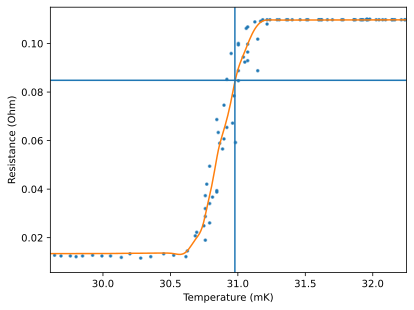

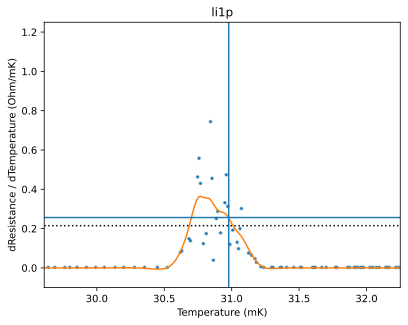

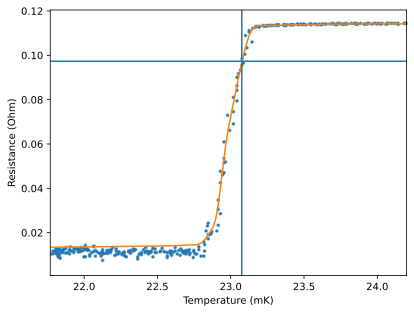

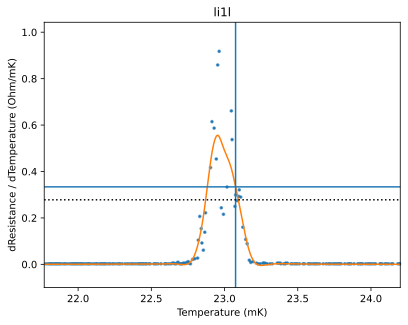

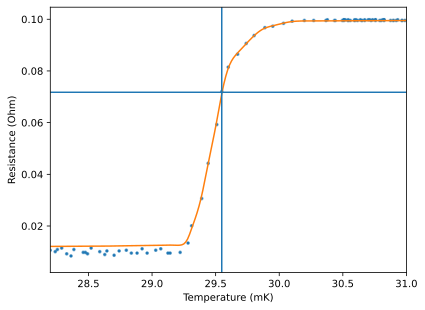

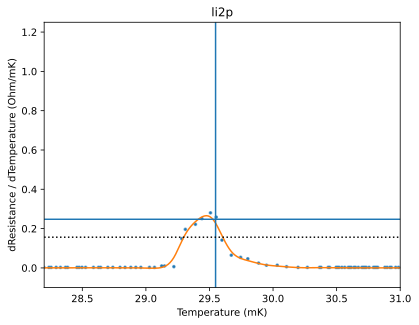

In [43]:
# eval derivative of transition curve at all OPs

T_op = {'li1p': temp_trafo(30.91, limits['li1p'], stretch['li1p']), 
        'li1l': temp_trafo(23.07, limits['li1l'], stretch['li1l']), 
        'li2p': temp_trafo(29.435, limits['li2p'], stretch['li2p']),}
dRdT_op = {'li1p': 0.205 / stretch['li1p'], 
           'li1l': 0.32 / stretch['li1l'], 
           'li2p': 0.198 / stretch['li2p']}

for name in names:

    plt.scatter(transition_curves[name][:,0], transition_curves[name][:,1], s=5, rasterized=True)
    plt.plot(temp_grids[name], transition_curve_splines[name], color='C1')
    plt.axhline(R_op[name])
    plt.axvline(T_op[name])
    plt.xlabel('Temperature (mK)')
    plt.ylabel('Resistance (Ohm)')
    plt.xlim(xlims[name])
    plt.show()

    plt.scatter(transition_curves_cleaned[name][:,0], 
                np.gradient(transition_curves_cleaned[name][:,1], transition_curves_cleaned[name][:,0]), s=5, rasterized=True)
    plt.plot(temp_grids[name], transition_curve_derivative_splines[name], color='C1')
    plt.axvline(T_op[name])
    plt.axhline(dRdT_op[name])
    plt.axhline(dRdT_op_linear[name], color='black', linestyle='dotted')
    plt.xlabel('Temperature (mK)')
    plt.ylabel('dResistance / dTemperature (Ohm/mK)')
    plt.xlim(xlims[name])
    plt.title(name)
    plt.ylim(-0.1,1 / stretch[name])
    plt.show()


In [44]:
# linearize the transition curve:
# around the OP it is roughly R(T + deltaT) = R_op + dRdT_op * deltaT
# we invert to deltaT = (R(T + deltaT) - R_op) / dRdT_op
# but this is also deltaT = (R(Vop + deltaVph) - R_op) / dRdT_op if we can linearize the R function as well

# linearize the function for the resistance:
# R(Vop + deltaVph) = Rref / (Ib / u / (Vop + deltaVph) - 1), with u = (I/phi_0) * (phi0/U) * sensitivitySQUID 
# the derivative for V at the OP is = u * Rref * Ib / (Ib - u * V_op) ** 2
# around the OP it is threfore linearized to R(Vop + deltaVph) = Rref / (Ib / u / Vop - 1) + u * Rref * Ib / (Ib - u * V_op) ** 2 * deltaVph

Vph_iron = {'li1p': 0.37, 'li1l': 3.3, 'li2p': 0.523}
R_iron = {}  # resistance increase for iron events
Tph_iron = {}

for name in names:
    
    R_iron[name] = utils_par['Rs'] / (bias[name] / v_to_muA / V_op[name] - 1) + v_to_muA * utils_par['Rs'] * bias[name] / (bias[name] - v_to_muA * V_op[name]) ** 2 * Vph_iron[name] 
    Tph_iron[name] = (R_iron[name] - R_op[name]) / dRdT_op[name]


In [45]:
Tph_iron

{'li1p': 0.019507743494039092,
 'li1l': 0.5389888446377264,
 'li2p': 0.019062463561196265}

# calc detector properties

In [46]:
# below are constants of nature

kB = 1.380649e-17  # mm ^ 2 * g / s^2 / mK     # nJ / mK
na = 6.02214076e23  # number of items per mole
h_const = 6.62607015e-34  # kg * m^2 / s
e_charge = 1.60217663e-19  # coulombs

In [47]:
density = {'W': 0.01935, 'Au': 0.01932, 'Al': 0.002702, 'CaWO4': 0.00606, 'Si': 0.00233, 'Al2O3': 0.00398, 'LiAlO2': 0.002615, 'Cu': 0.0089, }  # g/mm^3
molar_mass = {'W': 183.84, 'Au': 196.96655, 'Al': 26.981538, 'CaWO4': 287.9156, 'Si': 28.0855, 'Al2O3': 101.961276, 'LiAlO2': 65.92, 'Cu': 63.546, }  # g/mole

energy_gap = {'CaWO4': 5.2e-3, 'Si': 1.12e-3, 'Al203': 8.3e-3, 'LiAlO2': 4.59, 'Cu': 0.0, }  # keV
sommerfeld_constant = {'W': 1.01e3, 'Au': 0.729e3, 'Al': 1.356e3, 'Cu': 0.7e3, }  # pJ / mol / mK^2 ; gold value is from Florians book
fermi_temp = {'W': 27_000_000, 'Au': 63_900_000, 'Al': 134_900_000, 'Cu': 8_160_000, }  # mK
electron_phonon_coupling = {'W': 2.1e-4}  # pW / mK^6 / mm^3 - multiply with T^5 (mK) and volume (mm^3)
thermal_conductivity = {'Au': 17.1e3}  # pW / mK^2 / mm - multiply with temperature (mK) and cross section (mm^2), divide by length (mm) 


In [48]:
# speed of sound 
K_mod = {'LiAlO2': 94, 'Al2O3': 232, 'Si': 83, 'Cu': 39,}  # bulk modulus, GPa
G_mod = {'LiAlO2': 53, 'Al2O3': 149, 'Si': 63, 'Cu': 53,}   # shear modulus, GPa
s_long = {}
s_trans = {}
s_eff = {}

for name in ['LiAlO2', 'Al2O3', 'Si', 'Cu']:

    s_long[name] = np.sqrt( (K_mod[name] + 4/3*G_mod[name]) / density[name] * 1e3 ) # sqrt( 10**6 / s ** 2 / mm * mole )
    s_trans[name] = np.sqrt( G_mod[name] / density[name] * 1e3)  # sqrt( 10**6 / s ** 2 / mm * mole )
    s_eff[name] = ((1/3) * s_long[name] ** (-3) + (2/3) * s_trans[name] ** (-3) ) ** ( - 1 / 3)  # m/s
    

In [49]:
# atomic density lithium aluminate
n_atom = {}

for name in ['LiAlO2', 'Al2O3', 'Si', 'Cu']:
    n_atom[name] = density[name] / (molar_mass[name] / na) * 1e9  # 1/m^3
    print(name, n_atom[name])

LiAlO2 2.388940850637136e+28
Al2O3 2.3507081477481704e+28
Si 4.996025696818643e+28
Cu 8.43437081232493e+28


In [50]:
# Debye freqency is ω^3_D=6π^2nc^3. (https://lampx.tugraz.at/~hadley/ss1/phonons/table/dosdebye.html)

for name in ['LiAlO2', 'Al2O3', 'Si', 'Cu']:
    deb_freq = (6 * np.pi ** 2 * n_atom[name] * s_eff[name] ** 3) ** (1/3)  # rad / sec
    # deb_freq = (6 * np.pi ** 2 * n_atom[name] * s_long[name] ** 3) ** (1/3)  # rad / sec
    print('deb freq', name, deb_freq*1e-12/2/np.pi, 'in THz')
    # print(name, deb_freq * h_const / kB, 'in mK')
    td = deb_freq/2/np.pi * h_const / kB * 1e9 # mK
    print('deb temp', name, td, 'in mK')
    
# debye model phonon heat resistance
# http://lampx.tugraz.at/~hadley/ss2/transport/phonon_Boltzmann.php

deb freq LiAlO2 8.943137886280796 in THz
deb temp LiAlO2 429202.92554892146 in mK
deb freq Al2O3 12.051032854168913 in THz
deb temp Al2O3 578358.3595227894 in mK
deb freq Si 13.111905093419978 in THz
deb temp Si 629272.1969823111 in mK
deb freq Cu 7.216316271648248 in THz
deb temp Cu 346328.5588192781 in mK


In [51]:
# below are constants of the materials

debye_frequency = {'CaWO4': 4.7, 'Si': 13.5, 'Al2O3': 21.7,  # from pantic thesis , THz
                   'LiAlO2': 8.943, 'Cu': 7.22, }  # calc above
                # mK  # debye_temp * h_const / kB
debye_temp = {'W': 383_000, 'Au': 162_000, 'Al': 428_000, 'CaWO4': 228_000, 'Si': 648_000, 'Al2O3': 1_041_000,  # from pantic thesis 
              'LiAlO2': 429_202, 'Cu': 346_328, }  # mK  # calc above


In [52]:
abs_material = {'li1p': 'LiAlO2', 'li1l': 'Al2O3', 'li2p': 'LiAlO2', }
abs_volume = {'li1p': 4000, 'li1l': 200, 'li2p': 4000, }  # mm^3
abs_surface = {'li1p': 1600, 'li1l': 840, 'li2p': 1600, }  # mm^2

# phonon size M, light size S 
tes_thickness = {'li1p': 0.0002, 'li1l': 0.0002, 'li2p': 0.0002, }  # mm
tes_surface = {'li1p': 2.04, 'li1l': 1.02, 'li2p': 2.04, }  # mm^2 
pc_surface = {'li1p': 16.53, 'li1l': 7.6, 'li2p': 16.53, }  # mm^2
thermal_link_width = {'li1p': 0.040, 'li1l': 0.040, 'li2p': 0.040, }  # mm
thermal_link_thickness = {'li1p': 0.000080, 'li1l': 0.000080, 'li2p': 0.000080, }  # mm
thermal_link_length = {'li1p': 0.61, 'li1l': 1., 'li2p': 0.61, }  # mm


## copper holders

In [53]:
tau_holder = {'li1p': 200, 'li1l': 100, 'li2p': 200,}
volume_holder = dict([(name, 400) for name in names])

C_holder = {}

for name in names:
    mat = 'Cu'
    n_mol = volume_holder[name] * density[mat] / molar_mass[mat] 
    C_holder[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp[mat]) ** 3 * n_mol * 1e3

G_holder = dict([(name, C_holder[name]/tau_holder[name]) for name in names])

In [54]:
C_holder

{'li1p': 0.07792988021485098,
 'li1l': 0.03220986758627059,
 'li2p': 0.06762825062414256}

In [55]:
G_holder

{'li1p': 0.0003896494010742549,
 'li1l': 0.0003220986758627059,
 'li2p': 0.0003381412531207128}

## heat capacity absorber phonons and TES electrons

In [56]:
# values from literature

Ref: sisti (2001)

|  | No 1 | No 2 | No 3  | No 4  |
|---|---|---|---|---|
 | Toperating (mK) |  19.3 |  12.3 |  16.7  | 10 | 
 | Ca (pJ/mK)  | 0.1595 |  0.041.7 |  0.103  | 0.0221 | 

 **Thermometer** 
|  | No 1 | No 2 | No 3  | No 4  |
|---|---|---|---|---|
 | Thermometer Area (mm^2)  | 117  | 72  | 72 | 72 | 
 | Thermometer Thickness (mm) |  0.000210  | 0.000130  | 0.000180 |  0.000180 | 
 | Thermometer Rth (n.c.) (Ohm) |  0.193 |  0.160 |  0.210 |  0.290 | 
 | Thermometer Roperating (Ohm)  | 0.161  | 0.070  | 0.125 |  0.095 | 
 | Thermometer Ce (pJ/mK)  | 0.0677 |  0.022  | 0.036 |  0.0269 | 


In [57]:
print('sisti had this strength of e-ph coupling:', 16.7**5*72*0.000180*2.1e-4)
print('sisti had this strength of thermal link:', 22.4)

sisti had this strength of e-ph coupling: 3.5351402802801117
sisti had this strength of thermal link: 22.4


In [58]:
Cph_mm3 = {}  # pJ / mK / mm^3
Ce_mm3 = {}  # pJ / mK / mm^3
Cph = {}  # pJ / mK
Ce = {}  # pJ / mK
Cph_tes = {}  # pJ / mK  # we ignore this in the end!

for name in names:
    mat = abs_material[name]
    n_mol_mm3 = density[mat] / molar_mass[mat] 
    Cph_mm3[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp[mat]) ** 3 * n_mol_mm3 * 1e3
    
    n_mol = abs_volume[name] * density[mat] / molar_mass[mat] 
    Cph[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp[mat]) ** 3 * n_mol * 1e3
    
    n_mol_mm3 = density['W'] / molar_mass['W']
    Ce_mm3[name] = sommerfeld_constant['W'] * T_op[name] * (2.43 - 1.43 * R_op[name] / tes_rt0[name]) * n_mol_mm3 
    
    n_mol = tes_surface[name] * tes_thickness[name] * density['W'] / molar_mass['W']
    Ce[name] = sommerfeld_constant['W'] * T_op[name] * (2.43 - 1.43 * R_op[name] / tes_rt0[name]) * n_mol 
    
    n_mol = tes_surface[name] * tes_thickness[name] * density['W'] / molar_mass['W'] 
    Cph_tes[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp['W']) ** 3 * n_mol * 1e3

    

In [59]:
Cph  # same OOM than sisti

{'li1p': 0.11596697229437922,
 'li1l': 0.00016527820668310933,
 'li2p': 0.10063718107644044}

In [60]:
Ce  # factor 20 smaller than sisti (expected)

{'li1p': 0.0017831239759439708,
 'li1l': 0.000610291898064293,
 'li2p': 0.001799413555944006}

In [61]:
Cph_tes  # ignored

{'li1p': 4.4168214477555916e-08,
 'li1l': 9.127771888791909e-09,
 'li2p': 3.832957358684352e-08}

## Couplings

### calculate values from literature 

Ref: sisti (2001)

**Thermal coupling** 
|  | No 1 | No 2 | No 3  | No 4  |
|---|---|---|---|---|
 | Thermal coupling No. of Au wires  | 2 |  1 |  2 |  2 | 
 | Thermal coupling Diameter (mm)  | 0.025 |  0.025 |  0.025 |  0.025 | 
 | Thermal coupling Length (mm)  | 20 |  30  | 25  | 25 | 
 | Thermal coupling GAu (pW/mK) |  18.2 |  3.8 |  22.4 |  13.4 | 


In [62]:
# pantic

In [63]:
eph_coupling_calc = {}  # pW/mK
thermal_link_calc = {}  # pW/mK

for name in names:
    tes_vol = tes_surface[name] * tes_thickness[name] 
    eph_coupling_calc[name] = electron_phonon_coupling['W'] * T_op[name] ** 5 * tes_vol
    thermal_link_calc[name] = thermal_conductivity['Au'] * (T_op[name] + utils_par['T_mc'])/2 * thermal_link_width[name] * thermal_link_thickness[name] / thermal_link_length[name]
    

In [64]:
eph_coupling_calc  # do not match

{'li1p': 2.4442540022604495,
 'li1l': 0.28027942891157476,
 'li2p': 1.9298338044509766}

In [65]:
thermal_link_calc  # do not match

{'li1p': 2.062226360655738,
 'li1l': 1.0417416564705886,
 'li2p': 1.9980873442622953}

### get values from data

In [157]:
beta = {}
tau_film = {}
tau_crystal = {}
epsilon = {}

energy = (5.9 * 8/9 + 1/9 * 6.4) * 0.000160218

for name in names:
    beta[name] = - Afast[name] * Tph_iron[name] * Ce[name] / energy
    tau_crystal[name] = - tau_rise[name] / beta[name]
    tau_film[name] = tau_rise[name] / (1 + beta[name])
    epsilon[name] = tau_film[name] / (tau_film[name] + tau_crystal[name])

In [158]:
epsilon

{'li1p': 0.03795546645684357,
 'li1l': 0.2275330356782102,
 'li2p': 0.03389921745173118}

In [159]:
delta = {}
beta_tp = {}
tau_film_tp = {}
tau_crystal_tp = {}

energy = (5.9 * 8/9 + 1/9 * 6.4) * 0.000160218

for name in names:
    beta_tp[name] = - Afast_tp[name] * Tph_iron[name] * Ce[name] / energy
    tau_crystal_tp[name] = - tau_rise_tp[name] / beta_tp[name]
    tau_film_tp[name] = tau_rise_tp[name] / (1 + beta_tp[name])
    delta[name] = tau_film_tp[name] / (tau_film_tp[name] + tau_crystal_tp[name])

In [160]:
delta

{'li1p': 0.06968177003039981,
 'li1l': 0.08083783857078734,
 'li2p': 0.058819060204391656}

\begin{equation}
\begin{array}{l}C_{e} \frac{d T_{e}}{d t}+\left(T_{e}-T_{a}\right) G_{e a}+\left(T_{e}-T_{b}\right) G_{e b}=P_{e}(t) \\ C_{a} \frac{d T_{a}}{d t}+\left(T_{a}-T_{e}\right) G_{e a}+\left(T_{a}-T_{b}\right) G_{a b}=P_{a}(t)\end{array}
\end{equation}

\begin{equation}
\tau_{i n}=\frac{1}{s_{i n}}=\frac{2}{a+\sqrt{a^{2}-4 b}} \quad \tau_{t}=\frac{1}{s_{t}}=\frac{2}{a-\sqrt{a^{2}-4 b}}
\end{equation}

\begin{equation}
a = \frac{\tau_{in} + \tau_t}{\tau_{in} \tau_t}
\end{equation}

\begin{equation}
b = \frac{1}{\tau_{in} \tau_t}
\end{equation}

\begin{equation}
a=\frac{G_{e a}+G_{e b}}{C_{e}}+\frac{G_{e a}+G_{a b}}{C_{a}}
\end{equation}

\begin{equation}
b=\frac{G_{e a} G_{e b}+G_{e a} G_{a b}+G_{e b} G_{a b}}{C_{e} C_{a}}
\end{equation}

\begin{equation}
A_{n}=\frac{P_{0}\left(s_{i n}-\left(G_{a b} / C_{a}\right)\right)}{\varepsilon\left(s_{i n}-s_{t}\right)\left(s_{i n}-s_{n}\right)}\left(\frac{s_{t}-\left(G_{a b} / C_{a}\right)}{G_{e b}-\left(C_{e} / C_{a}\right) G_{a b}}-\frac{\varepsilon}{C_{e}}\right)
\end{equation}

\begin{equation}
A_{t}=\frac{P_{0}\left(s_{t}-\left(G_{a b} / C_{a}\right)\right)}{\varepsilon\left(s_{t}-s_{i n}\right)\left(s_{t}-s_{n}\right)}\left(\frac{s_{i n}-\left(G_{a b} / C_{a}\right)}{G_{e b}-\left(C_{e} / C_{a}\right) G_{a b}}-\frac{\varepsilon}{C_{e}}\right)
\end{equation}

In [161]:
def fit_couplings(x):
    
    Geff, Gab, Gae = x[0], x[1], x[2]
    
    # eps = x[3]
    eps = epsilon[name]
    
    energy = (5.9 * 8/9 + 1/9 * 6.4) * 0.000160218
    
    a = (tau_fast[name] + tau_slow[name])/(tau_fast[name] * tau_slow[name])
    b = 1/(tau_fast[name] * tau_slow[name])

    eq0 = (Gae+Geff)/Ce[name] + (Gae+Gab)/Cph[name] - a
    eq1 = (Gae*Geff + Gae*Gab + Geff*Gab)/Ce[name]/Cph[name] - b

    s_f = 1 / tau_fast[name]
    s_s = 1 / tau_slow[name]
    s_r = 1 / tau_rise[name]
    P0 = eps * energy / tau_rise[name]

    term0 = s_f - (Gab/Cph[name])
    term1 = s_f - s_s
    term2 = s_f - s_r
    term3 = s_f - Gab/Cph[name]
    term4 = Geff - Ce[name]/Cph[name]*Gab
    eq2 = P0 / eps * term0 / term1 / term2 * (term3/term4 - eps/Ce[name]) + Afast[name] * Tph_iron[name]

    term5 = s_s - (Gab/Cph[name])
    term6 = s_s - s_f
    term7 = s_s - s_r
    term8 = s_f - Gab/Cph[name]
    term9 = Geff - Ce[name]/Cph[name]*Gab
    eq3 = P0 / eps * term5 / term6 / term7 * (term8/term9 - eps/Ce[name]) - Aslow[name] * Tph_iron[name]
    
    penalty = 1e5 * np.sum([eps <= 0.001, eps >= 0.999, Geff <= 1e-7, Gab <= 1e-7, Gae <= 1e-5])
    
    return [eq0 + penalty, eq1, eq3]  # , eq2 ... this one has some issue??

In [162]:
from scipy.optimize import root

In [163]:
eph_coupling = {}  # pW/mK
G_eff = {}  # pW/mK
absorber_bath = {}  # pW/mK
fit_results = {}

for name in names:
    res = root(fit_couplings, [Ce[name]/tau_fast[name], Cph[name]/tau_slow[name], 1e-3], method='lm')
    
    fit_results[name] = res
    
    G_eff[name] = res.x[0]
    absorber_bath[name] = res.x[1]
    eph_coupling[name] = res.x[2]
    # epsilon[name] = res.x[3]

Needs some math.

In [73]:
# from sympy import solve, symbols, sqrt, nonlinsolve, nsolve, Function, Eq, Derivative, Heaviside, exp
# from sympy.solvers.ode.systems import dsolve_system

In [116]:
# Geff, Gae, C_e, C_a, t_f, t_s = symbols('G_eff eph_coupling Ce Cph tau_fast tau_slow')
# P0, eps, s_f, s_s, s_r, A_f, A_s, t_r, Gab = symbols('P0 epsilon s_fast s_slow s_rise A_fast A_slow tau_rise absorber_bath')
# dE, a, b, t_film, t_crystal = symbols('energy a b tau_film tau_crystal')

In [117]:
## try to solve ODE system symbolically, but this gives crazy long terms that are not useful!
# t, Tb = symbols('t Tb')
# P_e = Heaviside(t, 1) * P0 * exp(-t/t_r)
# P_a = (1-eps)/eps*P_e
# T_e = Function('Te')
# T_a = Function('Ta')
# eq1 = - P_e + C_e * Derivative(T_e(t), t) + (T_e(t) - T_a(t))*Gae + (T_e(t) - T_b)*Geff
# eq2 = - P_a + C_a * Derivative(T_a(t), t) + (T_a(t) - T_e(t))*Gae + (T_a(t) - T_b)*Gab
# sol = dsolve_system([eq1, eq2], [T_e(t), T_a(t)], t)

In [118]:
# a = (t_f + t_s)/(t_f*t_s)
# b = 1/(t_f*t_s)

# eq5 = (Gae+Geff)/C_e + (Gae+Gab)/C_a - a
# eq6 = (Gae*Geff + Gae*Gab + Geff*Gab)/C_e/C_a - b

# s_f = 1 / t_f
# s_s = 1 / t_s
# s_r = 1 / t_r
# P0 = eps * dE / t_r

# term0 = s_f - (Gab/C_a)
# term1 = s_f - s_s
# term2 = s_f - s_r
# term3 = s_f - Gab/C_a
# term4 = Geff - C_e/C_a*Gab
# eq7 = P0 / eps * term0 / term1 / term2 * (term3/term4 - eps/C_e) - A_f

# term5 = s_s - (Gab/C_a)
# term6 = s_s - s_f
# term7 = s_s - s_r
# term8 = s_f - Gab/C_a
# term9 = Geff - C_e/C_a*Gab
# eq8 = P0 / eps * term5 / term6 / term7 * (term8/term9 - eps/C_e) - A_s

In [143]:
# eph_coupling = {}  # pW/mK
# G_eff = {}  # pW/mK
# absorber_bath = {}  # pW/mK
# tols = {'li1p': 0.000008, 'li1l': 326679.08, 'li2p': 0.0000136}

# for name in names:
#     substitutions = {t_f: tau_fast[name], 
#                      t_s: tau_slow[name],
#                      t_r: tau_rise[name],
#                      C_e: Ce[name], 
#                      C_a: Cph[name],
#                      A_f: Afast[name]*Tph_iron[name],  # A_f needs be height iron pulse in temp times the A_fast component
#                      A_s: Aslow[name]*Tph_iron[name],  # A_s needs be height iron pulse in temp times the A_slow component
#                      dE:(5.9 * 8/9 + 1/9 * 6.4) * 0.000160218,  # iron peak in pJ
#                      eps: epsilon[name],
#                      }

#     a_ = a.subs(substitutions)
#     b_ = b.subs(substitutions)
#     eq5_ = eq5.subs(substitutions)
#     eq6_ = eq6.subs(substitutions)
#     s_f_ = s_f.subs(substitutions)
#     s_s_ = s_s.subs(substitutions)
#     s_r_ = s_r.subs(substitutions)
#     P0_ = P0.subs(substitutions)
#     eq7_ = eq7.subs(substitutions)  
#     eq8_ = eq8.subs(substitutions)  
#     eq9_ = eq9.subs(substitutions)  

#     sol = nsolve([eq5_, eq6_, eq7_, eq8_], 
#                  [Geff, Gae, Gab], 
#                  [Ce[name]/tau_fast[name], 1e-3, Cph[name]/tau_slow[name]], 
#                  dict=True, tol=tols[name])
#     for key, val in zip(sol[0].keys(), sol[0].values()):
#         eval(str(key))[name] = float(val)
        

In [136]:
# delta = {}
# delta_abs = {}

# for name in names:
#     substitutions = {t_f: tau_fast_tp[name], 
#                      t_s: tau_slow_tp[name],
#                      t_r: tau_rise_tp[name],
#                      C_e: Ce[name], 
#                      C_a: Cph[name],
#                      A_f: Afast_tp[name]*Tph_iron[name],  # A_f needs be height iron pulse in temp times the A_fast component
#                      A_s: Aslow_tp[name]*Tph_iron[name],  # A_s needs be height iron pulse in temp times the A_slow component
#                      dE:(5.9 * 8/9 + 1/9 * 6.4) * 0.000160218,  # iron peak in pJ
#                      Geff: G_eff[name], 
#                      Gae: eph_coupling[name], 
#                      Gab: absorber_bath[name],
#                      }

#     a_ = a.subs(substitutions)
#     b_ = b.subs(substitutions)
#     eq5_ = eq5.subs(substitutions)
#     eq6_ = eq6.subs(substitutions)
#     s_f_ = s_f.subs(substitutions)
#     s_s_ = s_s.subs(substitutions)
#     s_r_ = s_r.subs(substitutions)
#     P0_ = P0.subs(substitutions)
#     eq7_ = eq7.subs(substitutions)  
#     eq8_ = eq8.subs(substitutions)  

#     sol = nsolve([eq7_], [eps], [.9], dict=False)
#     sol_ = nsolve([eq8_], [eps], [.9], dict=False)

#     delta[name] = float(sol[0])  # (float(sol[0]) + float(sol_[0]))/2
#     delta_abs[name] = float(sol_[0])

In [164]:
epsilon

{'li1p': 0.03795546645684357,
 'li1l': 0.2275330356782102,
 'li2p': 0.03389921745173118}

In [165]:
delta

{'li1p': 0.06968177003039981,
 'li1l': 0.08083783857078734,
 'li2p': 0.058819060204391656}

In [166]:
eph_coupling

{'li1p': 0.04645185138021089,
 'li1l': 0.006166600690450879,
 'li2p': 0.046872394182735845}

In [167]:
for name in names:
    print('e-ph coupling smaller than calc: ', eph_coupling_calc[name]/eph_coupling[name])

e-ph coupling smaller than calc:  52.61908685305349
e-ph coupling smaller than calc:  45.45120447730527
e-ph coupling smaller than calc:  41.17207661565915


In [168]:
G_eff

{'li1p': 0.14390310451175223,
 'li1l': 0.1584309839069005,
 'li2p': 0.1020638554020016}

In [169]:
absorber_bath

{'li1p': 1.5759253623478904,
 'li1l': 0.0033921204758926866,
 'li2p': 1.2401974695144766}

In [170]:
# next we want to decouple the ETF and the bath

In [171]:
G_etf = {}  # pW/mK
I_f = {}  # muA
G_tot = {}

for name in names:
    I_f[name] = bias[name] - I_squid_op[name]
    G_etf[name] = utils_par['Rs'] ** 2 * bias[name] ** 2 * (utils_par['Rs'] - R_op[name]) / (utils_par['Rs'] + R_op[name]) ** 2 * dRdT_op[name]
    # G_etf[name] = I_f[name]**2 * dRdT_op[name] * (R_op[name] - utils_par['Rs'])/(R_op[name] + utils_par['Rs'])  # from pantic, this is wrong!
    G_tot[name] = G_eff[name] + (eph_coupling[name] * absorber_bath[name]) / (eph_coupling[name] + absorber_bath[name])

In [172]:
I_f  # muA

{'li1p': 4.73201387283237,
 'li1l': 1.4504712138728324,
 'li2p': 5.567433988439307}

In [173]:
G_etf

{'li1p': -0.029499551977882267,
 'li1l': -0.003653608569825815,
 'li2p': -0.036254108937517085}

In [174]:
G_eff

{'li1p': 0.14390310451175223,
 'li1l': 0.1584309839069005,
 'li2p': 0.1020638554020016}

In [175]:
G_tot

{'li1p': 0.1890249480008323,
 'li1l': 0.16061933652276972,
 'li2p': 0.1472292549619975}

In [176]:
thermal_link_calc

{'li1p': 2.062226360655738,
 'li1l': 1.0417416564705886,
 'li2p': 1.9980873442622953}

In [177]:
thermal_link = {}
G_comb = {}

for name in names:
    thermal_link[name] = G_eff[name] - G_etf[name]
    G_comb[name] = G_tot[name] - G_etf[name]

In [178]:
thermal_link

{'li1p': 0.1734026564896345,
 'li1l': 0.16208459247672632,
 'li2p': 0.13831796433951868}

In [179]:
G_comb

{'li1p': 0.21852449997871456,
 'li1l': 0.16427294509259555,
 'li2p': 0.18348336389951458}

In [180]:
residual_resistivity = {}

for name in names:
    residual_resistivity[name] = thermal_link_calc[name]/thermal_link[name]

In [181]:
residual_resistivity  # this is the correction factor from wire to film geometry!

{'li1p': 11.892703389921895,
 'li1l': 6.427147951278416,
 'li2p': 14.445609822291347}

### estimate effect of self heating on transition curve

In [182]:
for name in names:
    self_heating = utils_par['Rs'] ** 2 / (utils_par['Rs'] + R_op[name]) ** 2 * R_op[name] / G_comb[name] * bias[name]  # sweeps were done with 1 mu
    print('{} is heated by {} mK due to self heating'.format(name, self_heating))

li1p is heated by 0.19932243083221945 mK due to self heating
li1l is heated by 0.07540558337149296 mK due to self heating
li2p is heated by 0.3006623432988307 mK due to self heating


### calc heater resistance

Annahme:
    
Heater current = Heater level * Heater range * sqrt(Pulser attenuator / 100 * Pulse template + DAC/10)

In [194]:
heater_current = {'li1p': 0.336 * 14.28, 'li1l': 0.4 * 2.26, 'li2p': 0.5794 * 14.28, }
pulser_amplitude = {'li1p': 0.091, 'li1l': 0.025, 'li2p': 0.08, }
cpe_factor = {'li1p': 3.103, 'li1l': 0.04739, 'li2p': 3.446,}

In [291]:
heater_resistance = {}
particle_to_tp = {'li1p': 0.08, 'li1l': 0.057, 'li2p': 0.08, }   # this is from ratio of rise particles and decay times test pulse 

for name in names:  # cpe_factor[name]
    I_h = heater_current[name] * np.sqrt(pulser_amplitude[name])
    heater_resistance[name] = 10 * cpe_factor[name] / I_h ** 2 * particle_to_tp[name]

In [292]:
heater_resistance

{'li1p': 1.1849373818050846,
 'li1l': 1.3221620722061245,
 'li2p': 0.5033868618601446}

### cross check heater resistance and bath temp

In [272]:
open_loop_out = {'li1p': 1.58, 'li1l': 6.9, 'li2p': 1.52}

In [293]:
heater_resistance_from_bath = {}

for name in names:
    g_sum = thermal_link[name] + absorber_bath[name]
    I_h = heater_current[name] * np.sqrt(open_loop_out[name] / 10)
    heater_resistance_from_bath[name] = - R_op[name] * I_f[name] ** 2 + T_op[name] * G_comb[name] - utils_par['T_mc'] * (absorber_bath[name] * thermal_link[name] ** 2 / g_sum) 
    heater_resistance_from_bath[name] *= 1 / I_h ** 2 / (1 - absorber_bath[name] / g_sum * (1 - delta[name]))
    heater_resistance_from_bath[name] *= (T_op[name]**4/4 - utils_par['T_mc']**4/4) / (T_op[name] - utils_par['T_mc']) / T_op[name]**3 # adjust to debye temperature

In [294]:
heater_resistance_from_bath

{'li1p': 3.47173630335464,
 'li1l': 3.794843969935123,
 'li2p': 0.8738288148609032}

In [200]:
# TODO factor (7, 4, 14) mismatch ??

# extract tes fluct and emi from nps

In [201]:
slow_pulse_nps = {}
fast_pulse_nps = {}

for name in names:
    fast_pulse = single_pulse(utils_par['t'] - utils_par['record_length']/utils_par['sample_frequency']/4, 
                      0, Afast[name], tau_rise[name], tau_fast[name])
    slow_pulse = single_pulse(utils_par['t'] - utils_par['record_length']/utils_par['sample_frequency']/4, 
                          0, Aslow[name], tau_rise[name], tau_slow[name])
    slow_pulse_nps[name] = np.abs(np.fft.rfft(slow_pulse)) ** 2 * (2 / utils_par['record_length']) ** 2 * v_to_muA ** 2
    fast_pulse_nps[name] = np.abs(np.fft.rfft(fast_pulse)) ** 2 * (2 / utils_par['record_length']) ** 2 * v_to_muA ** 2

In [202]:
nps = {'li1p': np.loadtxt(path + 'Channel_0_NPS.xy', skiprows=3),
       'li1l': np.loadtxt(path + 'Channel_1_NPS.xy', skiprows=3),
       'li2p': np.loadtxt(path + 'Channel_5_NPS.xy', skiprows=3)}

for name in names:
    
    nps[name][:,1] *= (2 / utils_par['record_length']) ** 2  # V^2 / Hz
    nps[name][:,1] *= v_to_muA ** 2  # muA^2 / Hz

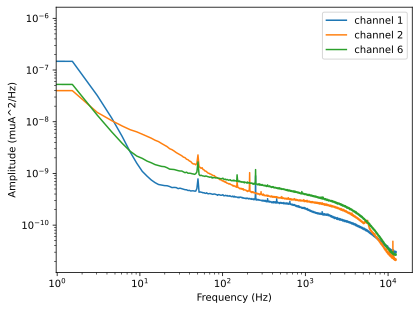

In [203]:
for name in names:
    plt.loglog(nps[name][:,0], 
               nps[name][:,1], label=f'channel {channels[name]}')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (muA^2/Hz)')
plt.show()

In [206]:
# noise functions

t_tot = {}  # s
t_comb = {}  # s
P_th_squared = {}  #1e-21 W^2/Hz
# i_sq = {}  # pA / sqrt(Hz)
S_squared = {}  # 1e-12 A^2/W^2
tes_branch = {}  # Ohm^-2
squid_branch = {}  # Ohm^-2
feedback_term = {}

thermal_noise = {}  # 1e-9 A^2/Hz  ==> muA^2/Hz (second number after multiplicative factor: * 1e-9 * 1e12)
thermometer_johnson = {}  # 1e-9 A^2/Hz ==> muA^2/Hz (... 1e-9 * 1e12)
shunt_johnson = {}  # 1e-9 A^2/Hz ==> muA^2/Hz (... 1e-9 * 1e12)
squid_noise = {}  # 1e-24 A^2/Hz ==> muA^2/Hz (... * 1e-24 * 1e12)  # i_sq in pA
one_f_noise = {}  # A^2/Hz ==> muA^2/Hz (... * 1e12)  # tes_fluct has units 1e3
emi_noise = {}  # 1e-9 A^2/Hz ==> muA^2/Hz (... 1e-9 * 1e12)  # p0: nJ * Ohm, p1: nJ * Ohm * Hz^2
total_noise = {}  # muA^2/Hz
t_in = {}

power_ts = np.sin(2 * np.pi * utils_par['t'] * 50)
power_component = np.abs(np.fft.rfft(power_ts)) ** 2 * (2 / utils_par['record_length']) ** 2 * v_to_muA ** 2

power_ts_two = np.sin(2 * np.pi * utils_par['t'] * 150)
power_component_two = np.abs(np.fft.rfft(power_ts_two)) ** 2 * (2 / utils_par['record_length']) ** 2 * v_to_muA ** 2

power_ts_three = np.sin(2 * np.pi * utils_par['t'] * 250)
power_component_three = np.abs(np.fft.rfft(power_ts_three)) ** 2 * (2 / utils_par['record_length']) ** 2 * v_to_muA ** 2

b, a = butter(N=1, Wn=5e3, btype='lowpass', analog=True)
_, h = freqs(b, a, worN=utils_par['freq'])

utils_par['lowpass'] = np.abs(h) ** 2

w_div = 1.

for name in names:
    t_tot[name] = Ce[name] / G_tot[name]
    
    t_comb[name] = Ce[name] / G_comb[name]
    
    P_th_squared[name] = 4*kB*T_op[name]**2*G_comb[name]*2/5*(1 - (utils_par['T_mc']/T_op[name])**5)/(1 - (utils_par['T_mc']/T_op[name])**2)
    
    S_squared[name] = lambda w: 1 / (1 + (w/w_div) ** 2 * t_tot[name] ** 2) / G_tot[name] ** 2 * (I_f[name] / (R_op[name] + utils_par['Rs'])) ** 2 * dRdT_op[name] ** 2
    
    tes_branch[name] = lambda w: (1 + (w/w_div) ** 2 * t_comb[name] ** 2) / (1 + (w/w_div) ** 2 * t_tot[name] ** 2) / (R_op[name] + utils_par['Rs']) ** 2 * (t_tot[name] / t_comb[name]) ** 2
    
    feedback_term[name] = (t_comb[name] / t_tot[name]) * (1 - 2 * R_op[name] / (R_op[name] + utils_par['Rs']) * I_f[name] ** 2 / G_tot[name] * dRdT_op[name])
    
    squid_branch[name] = lambda w: (feedback_term[name] ** 2 + (w/w_div) ** 2 * t_comb[name] ** 2) / (1 + (w/w_div) ** 2 * t_tot[name] ** 2) / (R_op[name] + utils_par['Rs']) ** 2 * (t_tot[name] / t_comb[name]) ** 2
    
    # the noise functions
    thermal_noise[name] = lambda w: S_squared[name](w) * P_th_squared[name] * 1e3 * utils_par['lowpass']
    
    thermometer_johnson[name] = lambda w: 4 * kB * T_op[name] * R_op[name] * tes_branch[name](w) * 1e3 * utils_par['lowpass']
    
    shunt_johnson[name] = lambda w: 4 * kB * utils_par['Rs'] * utils_par['T_mc'] * squid_branch[name](w) * 1e3 * utils_par['lowpass']
    
    squid_noise[name] = lambda w, i_sq: i_sq ** 2 * np.ones(w.shape) * 1e-12 * utils_par['lowpass']
    
    one_f_noise[name] = lambda w, tes_fluct, power: tes_fluct ** 2 / np.maximum(w,1) ** power * I_f[name] ** 2 * R_op[name] ** 2 * tes_branch[name](w) * utils_par['lowpass'] * 1e12  # tes_fluct has units 1e3
    
    emi_noise[name] = lambda w, p0, p1, p2, p3: (p0 ** 2 + p1 ** 2 * power_component + p2 ** 2 * power_component_two + p3 ** 2 * power_component_three) * squid_branch[name](w) * 1e3 * utils_par['lowpass']  # p0: nJ * Ohm, p1: nJ * Ohm * Hz^2
    
    # summed total
    total_noise[name] = lambda w, tes_fluct, power, p0, p1, p2, p3, excess_slow, excess_fast, i_sq: thermal_noise[name](w) + thermometer_johnson[name](w) + shunt_johnson[name](w) + \
    squid_noise[name](w, i_sq) + one_f_noise[name](w, tes_fluct, power) + emi_noise[name](w, p0, p1, p2, p3) + excess_slow ** 2 * slow_pulse_nps[name] + excess_fast ** 2 * fast_pulse_nps[name]
    

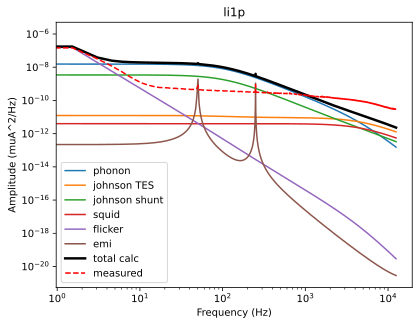

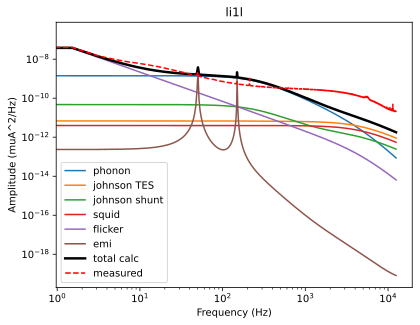

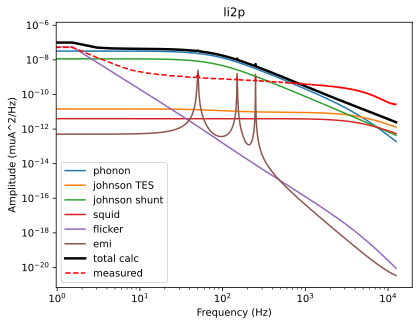

In [207]:
tes_fluct = {'li1p': 2e-10, 
             'li1l': 2.5e-10, 
             'li2p': 1e-10, }
power = {'li1p': 3., 
         'li1l': 1.5, 
         'li2p': 3., }
p0 = {'li1p': 0., 
      'li1l': 0., 
      'li2p': 0., }
p1 = {'li1p': 3e-8, 
      'li1l': 2.5e-7, 
      'li2p': 2e-8, 
     }
p2 = {'li1p': 0., 
      'li1l': 2e-7, 
      'li2p': 3e-8, 
     }
p3 = {'li1p': 5e-8, 
      'li1l': 0., 
      'li2p': 4e-8, 
     }
excess_slow = {'li1p': 0., 
               'li1l': 0., 
               'li2p': 0., }
excess_fast = {'li1p': 0., 
               'li1l': 0., 
               'li2p': 0., }
i_sq = 2.

details = True

for name in names:

    if details:
        plt.plot(utils_par['freq'], thermal_noise[name](utils_par['freq']), label='phonon')
        plt.plot(utils_par['freq'], thermometer_johnson[name](utils_par['freq']), label='johnson TES')
        plt.plot(utils_par['freq'], shunt_johnson[name](utils_par['freq']), label='johnson shunt')
        plt.plot(utils_par['freq'], squid_noise[name](utils_par['freq'], i_sq), label='squid')
        plt.plot(utils_par['freq'], one_f_noise[name](utils_par['freq'], tes_fluct[name], power[name]), label='flicker')
        plt.plot(utils_par['freq'], emi_noise[name](utils_par['freq'], p0[name], p1[name], p2[name], p3[name]), label='emi')
        # plt.plot(utils_par['freq'], excess_slow[name] ** 2 * slow_pulse_nps[name] * utils_par['lowpass'], label='excess_slow')
        # plt.plot(utils_par['freq'], excess_fast[name] ** 2 * fast_pulse_nps[name] * utils_par['lowpass'], label='excess_fast')
        
    noise_calc = (total_noise[name](utils_par['freq'], tes_fluct[name], power[name], p0[name], p1[name], p2[name], p3[name], excess_slow[name], excess_fast[name], i_sq))**(1)
    noise_meas = (nps[name][:,1])**(1)

    plt.plot(utils_par['freq'], noise_calc, color='black', linewidth=2.5, label='total calc')
    plt.plot(nps[name][:,0], noise_meas, label='measured', color='red', linewidth=1.5, linestyle='dashed')
    
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.title(name)
    plt.ylabel('Amplitude (muA^2/Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.show()

# pars dict

In [240]:
pars = {}

for name in names:

    pars[name] = {
        'C': np.array([Ce[name], Cph[name]]),  # pJ / mK, is defined later bec mutable
        'Gb': np.array([thermal_link[name], absorber_bath[name]]),  # pW / mK
        'G': np.array([[0., eph_coupling[name]], [eph_coupling[name], 0.], ]),  # heat cond between components, pW / mK
        'lamb': tau_rise[name],  # thermalization time (s)
        'eps': np.array([[epsilon[name], 1 - epsilon[name]], [epsilon[name], 1 - epsilon[name]], ]),  # share thermalization in components
        'delta': np.array([[delta[name], 1 - delta[name]], [delta[name], 1 - delta[name]], ]),  # share thermalization in components
        'Rs': np.array([utils_par['Rs']]),  # Ohm
        'Rh': np.array([heater_resistance_from_bath[name]]),  # Ohm
        'L': np.array([utils_par['L']]),  # H
        'Rt0': np.array([tes_rt0[name]]),  # Ohm
        'k': np.array([tes_width[name]/2]),  # 1/mK
        'Tc': np.array([T_op[name]]),  # mK
        'Ib': np.array([bias[name]]),  # muA
        'dac': np.array([open_loop_out[name]]),  # V
        'pulser_scale': np.array([pulser_amplitude[name]]),  # scale factor
        'heater_attenuator': np.array([1.]),  # TODO should be different
        'tes_flag': np.array([True, False], dtype=bool),  # which component is a tes
        'heater_flag': np.array([False, True], dtype=bool),  # which component has a heater
        'i_sq': np.array([2 * 1e-12]),  # squid noise, A / sqrt(Hz)  # TODO fix units
        'tes_fluct': np.array([2e-10]),  # ??  # TODO fix units
        'emi': np.array([2e-10]),  # ??  # TODO fix units and only the peaks
        'Tb': lambda t: utils_par['T_mc'],  # function that takes one positional argument t, returns Tb
        'tau': np.array([0.1]),
    }


# test with cryosig

In [241]:
import cryoenv.cryosig as cs

In [242]:
det = cs.DetectorModule(**pars[name])

In [255]:
det.set_control(dac=[50.05], Ib=[5], norm=False)

In [265]:
det.wait(5)

In [266]:
det.trigger(er=np.array([0., 0.]), tpa=np.array([1000.]), verb=True)

T0 is [30.0806879  35.40413687] mK.
Calculated in 0.011907100677490234 s.
Generated noise in 0.0037698745727539062 s.


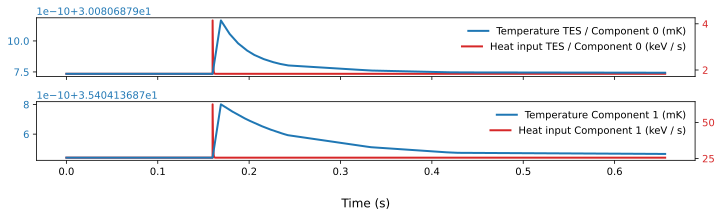

In [267]:
det.plot_temperatures()  # save_path='plots_paper/temperatures.png')

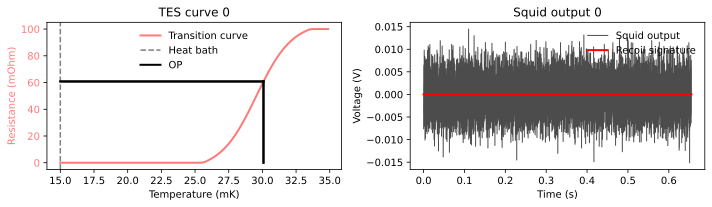

In [268]:
det.plot_tes()  # save_path='plots_paper/tes.png')

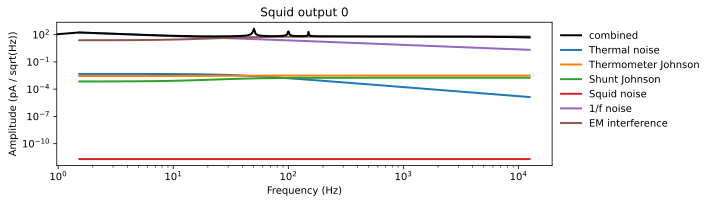

In [269]:
for i in range(det.nmbr_tes):
    det.plot_nps()  # tes_channel=i, only_sum=False, save_path='plots_paper/nps_tes_{}.png'.format(i))

# test with cryosig with 2 tes

In [ ]:
# TODO